In [1]:
import pandas as pd
import random as random
import numpy as np

# Pretty and Not Messy Code

## Step 1. Defining variables 

Knapsack problem:
* n - number of items to pack
* total_weight - maximum weight allowed to pack
* reward - value of a package 
* weight - weight of a package
* population_size

TSP:
* n_cities - number of cities on a unit circle
* population_size_cities

In [2]:
# # Knapsack problem:

# n = 4
# total_weight = 20
# reward  = [random.randint(1, 10) for _ in range(n)] # range(1,10)
# weight = [random.randint(1, 10) for _ in range(n)] # range(1,10)
# population_size = 10

# # Print to check
# print(weight)
# print(reward)

[4, 9, 6, 10]
[4, 7, 2, 3]


In [3]:
# TSP:
n_cities = 4
population_size_cities = 10

crossover_prob_cities = 0.8
mutation_prob_cities = 0.2
n_generations = 20

# Step 2. Create population

Knapsack problem:
Given the number of parcels, create all possible binary strings. Then randomly choose k binary strings. These are our initial population. Create Filter function that removes elemts that exceed the weight limit. Apply it before the first iteration. In the future, apply it after every next evolutionary step.

TSP:
* Add index[0] to index[len(n) + 1]
* Randomly shuffle numbers from 1 to n - do it k times (k<n!) - now we have population size k

In [61]:
# Knapsack problem:

def generate_binary_strings(n, population_size=10):
    '''
    Input:
    Output:
    '''
    if n == 0:
        return ['']
    else:
        previous_strings = generate_binary_strings(n - 1)
        new_strings = [string + '0' for string in previous_strings] + [string + '1' for string in previous_strings]
        population = random.sample(new_strings, min(population_size, len(new_strings)))
        return population
    

### Sanity pre-filtering 
# In order to reduce the intial population to hopefully save some time, we firstly check if there is an individual in the population which weight exceeds the total weight allowed
def pre_filter(n, total_weight, weight, filtered_population):
    for indiv in filtered_population:
        indiv_weight = 0
        for i in range(n):
            if indiv[i] == '1':
                indiv_weight += weight[i]
        if indiv_weight > total_weight:
            filtered_population.remove(indiv)
    return filtered_population



In [5]:
# TSP:

from itertools import permutations
# Maybe we can combine it to make a general population generator / have a switch / or add ectra if-else
def cities_population(list_of_cities, population_size=10):
    cities_permutations = []
    possible_permutations = list(permutations(list_of_cities))
    random_cities = random.sample(range(0, len(possible_permutations)), population_size)
    
    for i in random_cities:
        cities_permutations.append(list(possible_permutations[i]))
    return cities_permutations

def total_dist_permutation(permutation_individual):
#total distance calculated for one permutation
    total_dist = 0
    for i in range(0, len(permutation_individual)):
        if(i == len(permutation_individual) - 1):
            total_dist += dist_cities(permutation_individual[i], permutation_individual[0])
        else:
            total_dist += dist_cities(permutation_individual[i], permutation_individual[i+1])
    return total_dist

# Step 3. Compute Fitness

Knapsack Problem 
* Function to compute total value of a given individual
* Compute Fitness - calculate total value of each individual by summing the values of each parcel that is included
* Selection (for future crossover) - use Roulette Wheel to choose 2 parents

TSP:
* Function to compute distance between city1 & city2 
* Compute Fitness - sum of distances per individual
* Selection (for future crossover) - use Roulette Wheel to choose 2 parents

In [62]:
# Knapsack:

# indiv_reward_list = []

def fitness(n, reward, filtered_population, indiv_reward_list):
    for indiv in filtered_population:
        indiv_reward = 0
        for i in range(n):
            if indiv[i] == '1':
                indiv_reward += reward[i]
        indiv_reward_list.append(indiv_reward)
    return indiv_reward_list



# Roulette Wheel part goes here

def roulette_wheel_selection(population, fitness_probs):
    # Calculate the cumulative sum of fitness probabilities
    cumsum_probs = fitness_probs.cumsum()

    random_prob = np.random.uniform(0, 1)
    
    # Find the index of the first element in the cumulative sum array
    # greater than the random probability
    selected_index = np.argmax(cumsum_probs > random_prob)

    selected_individual = population[selected_index]
    
    return selected_individual


def heavy_kiddo(kid, n, total_weight, weight):
    indiv_weight = 0
    for i in range(n):
        if kid[i] == '1':
            indiv_weight += weight[i]
    if indiv_weight > total_weight:
        return True
    return False

In [66]:
# TSP:

def fitness_travelling(population):

    all_permutations_distance = []
    
    for i in range (0, len(population)):
        all_permutations_distance.append(total_dist_permutation(population[i]))

    population_fitness_sum = sum(max(all_permutations_distance) - all_permutations_distance)
    population_fitness_sum = sum(max(all_permutations_distance) - all_permutations_distance)
    if population_fitness_sum != 0:
        population_fitness_probs = (max(all_permutations_distance) - all_permutations_distance) / population_fitness_sum
    else:
        # Handle division by zero or NaN appropriately (e.g., set probabilities to equal values)
        population_fitness_probs = [1 / len(all_permutations_distance)] * len(all_permutations_distance)

    return population_fitness_probs

# Roulette Wheel part goes here


# chat gpted
def roulette_wheel_selection(population, fitness_probs):
    # Calculate the cumulative sum of fitness probabilities
    cumsum_probs = fitness_probs.cumsum()

    selected_individuals = []
    for _ in range(2):  # Select two individuals
        while True:
            # Generate a random probability
            random_prob = np.random.uniform(0, 1)

            # Find the index of the first element in the cumulative sum array
            # greater than the random probability
            selected_index = np.argmax(cumsum_probs > random_prob)

            selected_individual = population[selected_index]

            # Check if the selected individual is already in the list
            if selected_individual not in selected_individuals:
                selected_individuals.append(selected_individual)
                break
    return selected_individuals[0], selected_individuals[1]



# Step 4. Crossover

Knapsack problem:
* Create and use Double point crossover

TSP:
* Create and use Cycle crossover

In [63]:
# Knapsack:

def double_point_crossover(parent1, parent2, prob_double_point_crossover, mutation_prob):

    # print("Parents",parent1, parent2)

    # Check if crossover happens
    rand = random.random()
    # print("Random number", rand)

    if rand <= prob_double_point_crossover:
        # Add crossover switch
        # print("Crossover started")
        # Choose two random crossover points
        point1 = random.randint(0, len(parent1) - 1)
        point2 = random.randint(point1, len(parent1)-1)
        # print("Points", point1, point2)

        # Perform crossover
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]

        # print("Kids",child1, child2)

        rand = random.random()

        if rand <= mutation_prob:
            child1, child2 = mutation(child1, child2)

        return child1, child2

    else:
        rand = random.random()

        if rand <= mutation_prob:
            parent1, parent2 = mutation(parent1, parent2)
            # print("Mutation happened", parent1, parent2)

        return parent1, parent2





In [9]:
# TSP
def crossover(parent1, parent2, list_of_cities):

    n = len(list_of_cities)
    rand = random.randint(1, n - 1)

    offspring1 = []
    offspring2 = []

    offspring1.extend(parent1[:rand])
    offspring1.extend(city for city in parent2 if city not in offspring1)
    
    offspring2.extend(parent2[:rand])
    offspring2.extend(city for city in parent1 if city not in offspring2)
    
    return offspring1, offspring2

import random

# Define crossover (Cycle Crossover)
def cycle_crossover(parent1, parent2):
    # Initialize child with -1 indicating unvisited cities
    child = [-1] * len(parent1)
    
    # Randomly select a starting index
    idx = random.randint(0, len(parent1) - 1)
    
    while True:
        # Copy selected city from parent 1 to child
        child[idx] = parent1[idx]
        
        # Find the corresponding city from parent 2
        corresponding_city = parent2[idx]
        
        # Find the index of the corresponding city in parent 1
        idx = parent1.index(corresponding_city)
        
        # If the corresponding city is already in the child, the cycle is complete
        if child[idx] != -1:
            break
    
    # Fill in remaining unvisited cities from parent 2
    for i in range(len(parent2)):
        if child[i] == -1:
            child[i] = parent2[i]
    
    return child

# Example of applying crossover
parent1 = [3, 1, 4, 2, 5]
parent2 = [5, 2, 4, 1, 3]

offspring = cycle_crossover(parent1, parent2)
print("Offspring after crossover:", offspring)


Offspring after crossover: [5, 1, 4, 2, 3]


# Step 5. Mutation

Knapsack: 
* Mutation - switch 0 to 1 or 1 to 0 in a random bit of an individual

TSP:
* Mutation - swap 2 numbers in an indivual

Мутация - внутри ребенка; кроссовер - свап родителей 

In [64]:
# Knapsack:

def mutation(offspring1, offspring2):

     #print("Before mutation", offspring1, offspring2)

    random_child = random.choice(['1', '2'])
    if random_child == '1':
        mutated = offspring1
    else:
        mutated = offspring2

    point = random.randint(0, len(offspring1) - 1)

    # print("Mutated point", point)

    # Convert the string to a list of characters
    mutated_list = list(mutated)

    # Change the character at the selected index
    mutated_list[point] = '0' if mutated_list[point] == '1' else '1'

    # Convert the list back to a string
    mutated = ''.join(mutated_list)

    if random_child == '1':
        # print("After mutation", mutated, offspring2)
        return mutated, offspring2
    else:
        # print("After mutation", offspring1, mutated)
        return offspring1, mutated

In [11]:
# TSP

def mutation(offspring, list_of_cities):

    n = len(list_of_cities)
    
    # Select two random indices for mutation
    i_1 = random.randint(0, n - 1)
    i_2 = random.randint(0, n - 1)
    
    # Swap the cities at the selected indices
    offspring[i_1], offspring[i_2] = offspring[i_2], offspring[i_1]
    
    return offspring



# Step 6. Putting everything together

## Knapsack

here goes knapsack comment


Weights of parcels: [6, 7, 1, 7, 2]
Rewards for parcels: [7, 7, 10, 5, 10]
Population: ['01000', '01110', '01100', '00010', '01111', '01001', '01011', '00100', '10000', '11110', '00001', '11001', '01010', '00000', '00011', '10001', '11000', '01101', '00101', '11111']
Population after first filtering: ['01000', '01110', '01100', '00010', '01111', '01001', '01011', '00100', '10000', '00001', '11001', '01010', '00000', '00011', '10001', '11000', '01101', '00101']
Population size was reduced to 98.2
iteration  0
Current population ['01000', '01110', '01100', '00010', '01111', '01001', '01011', '00100', '10000', '00001', '11001', '01010', '00000', '00011', '10001', '11000', '01101', '00101']
Its reward list [7, 22, 17, 5, 32, 17, 22, 10, 7, 10, 24, 12, 0, 15, 17, 14, 27, 20]
Selected individual 1: 00001
Selected individual 2: 01111
Filtered population before crossover: ['01000', '01110', '01100', '00010', '01001', '01011', '00100', '10000', '11001', '01010', '00000', '00011', '10001', '1100

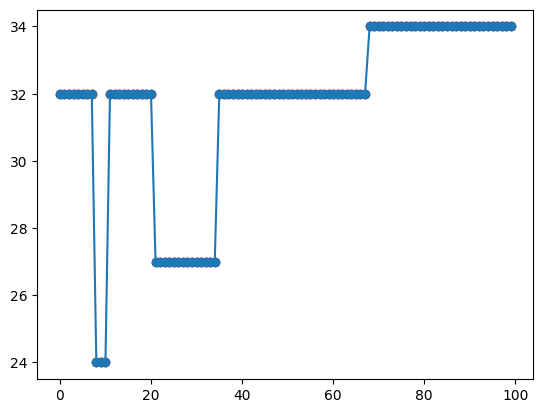

In [79]:
import matplotlib.pyplot as plt


n = 5 # number of boxes
total_weight = 20
reward  = [random.randint(1, 10) for _ in range(n)] # range(1,10)
weight = [random.randint(1, 10) for _ in range(n)] # range(1,10)
population_size = 10

# Print to check
print("Weights of parcels:", weight)
print("Rewards for parcels:", reward)

iterations = 100
prob_double_point_crossover = 0.8
mutation_prob = 0.2
population_size = 1000


population = generate_binary_strings(n, population_size)
print("Population:", population)

filtered_population = population.copy()

filtered_population = pre_filter(n, total_weight, weight, population)
print("Population after first filtering:", filtered_population)
print("Population size was reduced to", (100 - len(filtered_population)*100/(population_size)))

initial_filtered_population_size = len(filtered_population)

fittest_over_time = []

for i in range(0, iterations):

    print("iteration ", i)

    indiv_reward_list = []
    print("Current population", filtered_population)

    # Compute gains from all individuals in current population
    indiv_reward_list = fitness(n, reward, filtered_population, indiv_reward_list)
    print("Its reward list", indiv_reward_list)

    # Compute fitness probabilities
    fitness_probs = np.array(indiv_reward_list) / sum(indiv_reward_list)

    # Perform selection and crossover
    selected_individual1, selected_individual2 = roulette_wheel_selection(filtered_population, fitness_probs)
    
    print("Selected individual 1:", selected_individual1)
    index_to_remove = filtered_population.index(selected_individual1)
    filtered_population.pop(index_to_remove)

    print("Selected individual 2:", selected_individual2)
    index_to_remove = filtered_population.index(selected_individual2)
    filtered_population.pop(index_to_remove)

    print("Filtered population before crossover:", filtered_population)

    # Apply crossover
    offspring1, offspring2 = double_point_crossover(selected_individual1, selected_individual2, prob_double_point_crossover, mutation_prob)

    if(heavy_kiddo(offspring1, n, total_weight, weight)):
        print("Kid got too heavy, we took a parent instead")
        offspring1 = selected_individual1

    if(heavy_kiddo(offspring2, n, total_weight, weight)):
        print("Kid got too heavy, we took a parent instead")
        offspring2 = selected_individual2

    filtered_population.append(offspring1)
    filtered_population.append(offspring2)

    assert(initial_filtered_population_size == len(filtered_population))

    fittest_over_time.append(indiv_reward_list[np.argmax(indiv_reward_list)])



print(fittest_over_time)
print("The fittest indiv has value:",indiv_reward_list[np.argmax(indiv_reward_list)])


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the line
ax.plot(fittest_over_time, marker='o', linestyle='-')

# Add blobs at each point
ax.scatter(range(len(fittest_over_time)), fittest_over_time, color='red')

# Show the plot
plt.show()

# Implement Roulette - done
# Make sure population size stays the same - done
# Add filtering for obese kids - done
# Check "population reduced by" - done
# Return fittest individual in the end - done
# Plot fittest individual over time - done
# Improve, but how - TODO maybe keep the fittest always
# Come up with experiments - TODO
# Write report on these experiments - TODO

## TSP

here goes tsp comment

In [35]:
def tsp(list_of_cities, population_size, n_generations,
        crossover_per, mutation_per):
    
    population = cities_population(list_of_cities, population_size)
    fitness_probs = fitness_travelling(population)
    
    parents_list = []
    for i in range(0, int(crossover_per * population_size)):
        parents_list.append(roulette_wheel_selection(population,
                                                     fitness_probs))

    offspring_list = []    
    for i in range(0, len(parents_list), 2):
        offspring1, offspring2 = crossover(parents_list[i], parents_list[i+1], list_of_cities)

        print(offspring1)
        print(offspring2)

        mutate_threshold = random.random()
        if mutate_threshold > (1 - mutation_per):
            offspring1 = mutation(offspring1, list_of_cities)
            print("Offspring 1 mutated", offspring1)

        mutate_threshold = random.random()
        if mutate_threshold > (1 - mutation_per):
            offspring2 = mutation(offspring2, list_of_cities)
            print("Offspring 2 mutated", offspring2)

        offspring_list.append(offspring1)
        offspring_list.append(offspring2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_travelling(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[:population_size]
    best_mixed_offspring = [mixed_offspring[i] for i in best_fitness_indices]

    for _ in range(n_generations):
        fitness_probs = fitness_travelling(best_mixed_offspring)
        parents_list = []
        for _ in range(int(crossover_per * population_size)):
            parents_list.append(roulette_wheel_selection(best_mixed_offspring, 
                                               fitness_probs))

        offspring_list = []    
        for i in range(0, len(parents_list), 2):
            offspring1, offspring2 = crossover(parents_list[i], 
                                               parents_list[i+1], list_of_cities)

            mutate_threshold = random.random()
            if mutate_threshold > (1 - mutation_per):
                offspring1 = mutation(offspring1, list_of_cities)

            mutate_threshold = random.random()
            if mutate_threshold > (1 - mutation_per):
                offspring2 = mutation(offspring2, list_of_cities)

            offspring_list.append(offspring1)
            offspring_list.append(offspring2)

        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_travelling(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[:int(0.8 * population_size)]
        best_mixed_offspring = [mixed_offspring[i] for i in best_fitness_indices]
            
        old_population_indices = random.sample(range(population_size), int(0.2 * population_size))
        for i in old_population_indices:
            best_mixed_offspring.append(population[i])
            
        random.shuffle(best_mixed_offspring)
            
    return best_mixed_offspring

# Define your parameters
list_of_cities = ['Barcelona', 'Krakow', 'Reykjavik', 'Marseille', 'Prague', 'Dublin', 'Athens', 'Stockholm', 'Budapest', 'Edinburgh']

# Call the function to get the best mixed offspring
result = tsp(list_of_cities, population_size, n_generations, crossover_per, mutation_per)

# Print the order of cities for each individual in the result
for individual in result:
    print("Order of cities:", individual)



NameError: name 'crossover_per' is not defined

# Experiments Brainstorm

TSP: increase the number of citites aka angle change untill it starts breaking

Knapsack: Experiment ratio weight range and max weight allowed

# Outline TSP

1. Input - n - number of cities
2. Compute gamma: 360/n
3. Randomly shuffle numbers from 1 to n - do it k times (k<n!) - now we have population size k
4. Create a function that computes all distance between city1 and city2 - outputs distance
5. Compute Fitness - weight - which is a sum of distances per individual
6. Use Roulette Wheel to choose 2 parents
7. Do Cycle Crossover
8. Mutation - swap 2 cities
9. Update the population 

# Outline Knapsack
1. Input n - number of boxes; 
2. input max weight, create random values per box
3. Create all possible binary strings and choose randomly k indiv
* Create Filter function
* Use on initial population
4. Create a function that computes the value of a given indiv
5. Compute fitness - value (same as tsp)
6. Selection - Use Roulette Wheel to choose 2 parents
7. Do double point crossover 
8. Mutation - switch one 0 to 1 or 1 to 0
9. Updae the population
